In [1]:
import pyspark
from pyspark import RDD
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DoubleType, BooleanType, TimestampType, DateType, DecimalType, ArrayType, MapType, Row
from pyspark.sql.functions import to_date, date_format,col, count

In [2]:
!pip install mlflow

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from wordcloud import WordCloud

from google.colab import drive


In [4]:
MAX_MEMORY = "15G"  # Ensure it's defined before using

conf = pyspark.SparkConf() \
    .setMaster("local[*]") \
    .set("spark.executor.heartbeatInterval", "60s") \
    .set("spark.network.timeout", "300s") \
    .set("spark.sql.shuffle.partitions", "200") \
    .set("spark.executor.memory", MAX_MEMORY) \
    .set("spark.driver.memory", MAX_MEMORY) \
    .set("spark.driver.maxResultSize", "10G")  # Adjust as needed

spark = SparkSession.builder.config(conf=conf).getOrCreate()
print("Spark Session Created Successfully!")

Spark Session Created Successfully!


In [5]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
filename_data = "/content/drive/MyDrive/netflix_titles.csv"  # Adjust if placed in a folder

df = spark.read.csv(filename_data, header=True, inferSchema=True)

df.show(3)

+-------+-------+--------------------+---------------+--------------------+-------------+------------------+------------+------+---------+--------------------+--------------------+
|show_id|   type|               title|       director|                cast|      country|        date_added|release_year|rating| duration|           listed_in|         description|
+-------+-------+--------------------+---------------+--------------------+-------------+------------------+------------+------+---------+--------------------+--------------------+
|     s1|  Movie|Dick Johnson Is Dead|Kirsten Johnson|                NULL|United States|September 25, 2021|        2020| PG-13|   90 min|       Documentaries|As her father nea...|
|     s2|TV Show|       Blood & Water|           NULL|Ama Qamata, Khosi...| South Africa|September 24, 2021|        2021| TV-MA|2 Seasons|International TV ...|After crossing pa...|
|     s3|TV Show|           Ganglands|Julien Leclercq|Sami Bouajila, Tr...|         NULL|Septem

In [7]:
df.printSchema()

root
 |-- show_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- country: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- listed_in: string (nullable = true)
 |-- description: string (nullable = true)



In [8]:
df.describe().show()

+-------+--------------------+-------------+---------------------------------+--------------------+--------------------+----------------+---------------+-----------------+-----------------+-------------+--------------------+--------------------+
|summary|             show_id|         type|                            title|            director|                cast|         country|     date_added|     release_year|           rating|     duration|           listed_in|         description|
+-------+--------------------+-------------+---------------------------------+--------------------+--------------------+----------------+---------------+-----------------+-----------------+-------------+--------------------+--------------------+
|  count|                8809|         8808|                             8807|                6173|                7983|            7977|           8796|             8807|             8803|         8804|                8806|                8806|
|   mean|       

In [9]:
# Get the number of rows and columns
num_rows = df.count()
num_cols = len(df.columns)

print(f"Dataset Shape: Rows = {num_rows}, Columns = {num_cols}")

Dataset Shape: Rows = 8809, Columns = 12


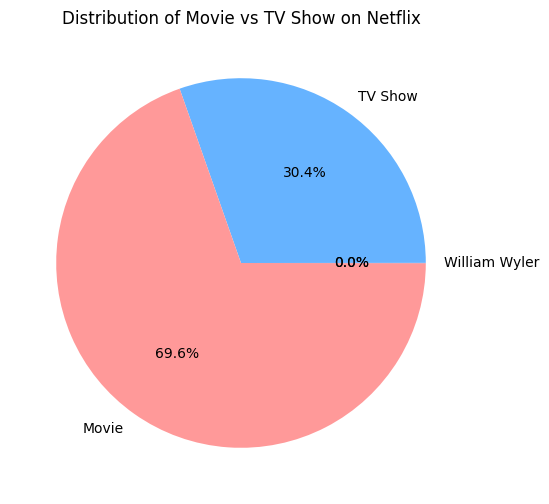

In [10]:
type_counts = df.groupBy("type").count().toPandas()  # Convert only small result set

# Plot using Matplotlib
plt.figure(figsize=(6, 6))
plt.pie(type_counts["count"], labels=type_counts["type"], autopct='%1.1f%%',
        colors=["#ff9999", "#66b3ff"])
plt.title("Distribution of Movie vs TV Show on Netflix")
plt.show()

In [11]:
distinct_years = [row["release_year"] for row in df.select("release_year").distinct().collect()]
print(distinct_years)

[' Ted Ferguson', '1987', '1956', '2016', '2020', '2012', '1958', '40 min', '1943', '1972', ' Marquell Manning', '1988', '2019', '2017', '1977', '2014', '1971', '1984', '2013', '1982', '2005', '2000', '1965', '1962', '1954', ' Charles Rocket', 'December 15, 2020', '1981', ' Peter Ferriero', '1978', '1974', '2002', '1959', ' Paul Sambo', '2018', '2009', 'United States', '1995', '1964', ' Dr. Dre', '1946', '2006', ' Nick Kroll', '1976', ' Imanol Arias', '1942', '1947', '1967', '1968', '2004', 'January 15, 2021', '2011', '1989', '1992', '1961', '1966', '2008', 'January 13, 2021', '1955', '1999', '1963', '1994', '1997', '1973', '1925', '2007', ' Kristen Johnston', '1996', 'June 12, 2021', '1983', ' Álvaro Cervantes', ' Nse Ikpe-Etim', '1969', ' Jade Eshete', '1980', '1944', '1960', '2021', ' Francis Weddey', '1986', '1985', 'August 13, 2020', '1979', '2015', '1998', '1993', '2001', '2010', '1990', '2003', '1991', '1945', '1975', '1970', None]


In [12]:
year_pattern = r"(\d{4})$"

df = df.withColumn(
    "release_year",
    when(regexp_extract(col("release_year"), year_pattern, 1) != "",
         regexp_extract(col("release_year"), year_pattern, 1))  # Extract year
    .otherwise(None)  # Remove invalid values
).dropna(subset=["release_year"])  # Drop rows with null release_year

# Convert release_year to Integer type
df = df.withColumn("release_year", col("release_year").cast("int"))

# Show cleaned DataFrame
#df_cleaned.select("release_year").distinct().show()
distinct_years_cleaned = [row["release_year"] for row in df.select("release_year").distinct().collect()]
print(distinct_years_cleaned)

[1959, 1990, 1975, 1977, 2003, 2007, 2018, 1974, 2015, 1955, 2006, 1978, 1925, 1961, 2013, 1942, 1944, 1956, 1997, 1988, 1994, 1968, 2014, 1973, 1979, 1946, 1947, 2019, 1971, 1966, 2004, 1991, 1967, 1969, 1982, 1945, 1996, 1989, 1943, 1998, 1963, 1965, 2020, 1985, 1960, 1970, 2012, 1987, 2009, 2016, 1995, 1980, 2001, 1972, 1992, 1958, 1983, 2005, 1954, 1984, 2000, 1964, 2010, 1981, 1986, 2011, 1976, 2008, 2017, 1999, 1962, 2002, 2021, 1993]


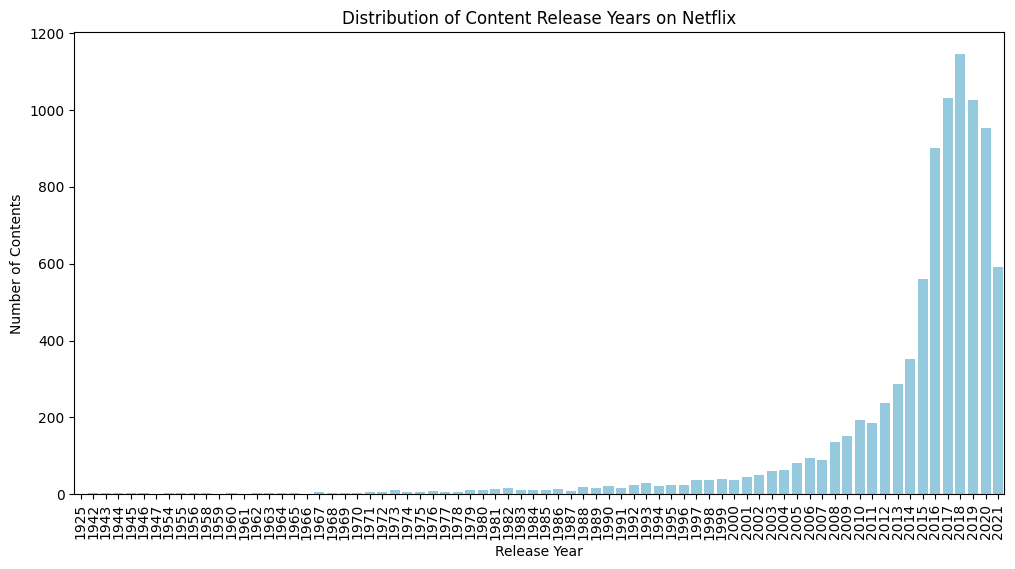

In [13]:
release_year_counts = df.groupBy("release_year").count().orderBy("release_year").toPandas()

# Plot using Matplotlib and Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=release_year_counts["release_year"], y=release_year_counts["count"], color="skyblue")
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.xlabel("Release Year")
plt.ylabel("Number of Contents")
plt.title("Distribution of Content Release Years on Netflix")
plt.show()

<ipython-input-14-681a2ff28f3b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts_pd["count"], y=country_counts_pd["country"], palette="coolwarm")


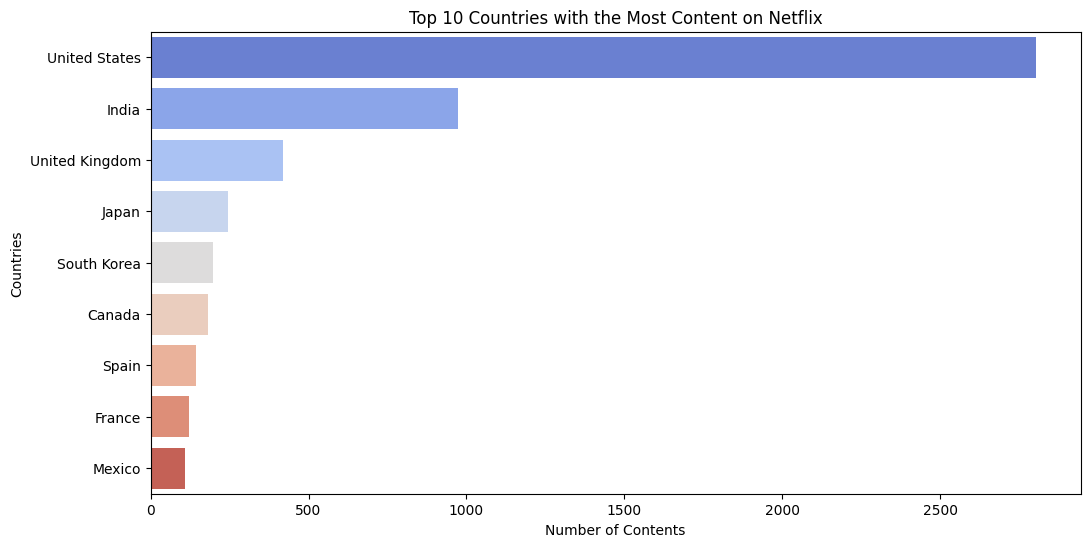

In [14]:


country_counts = df.groupBy("country").count().orderBy(col("count").desc())

# Convert to Pandas (limit to top 10 to avoid memory issues)
country_counts_pd = country_counts.limit(10).toPandas()

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=country_counts_pd["count"], y=country_counts_pd["country"], palette="coolwarm")
plt.xlabel("Number of Contents")
plt.ylabel("Countries")
plt.title("Top 10 Countries with the Most Content on Netflix")
plt.show()

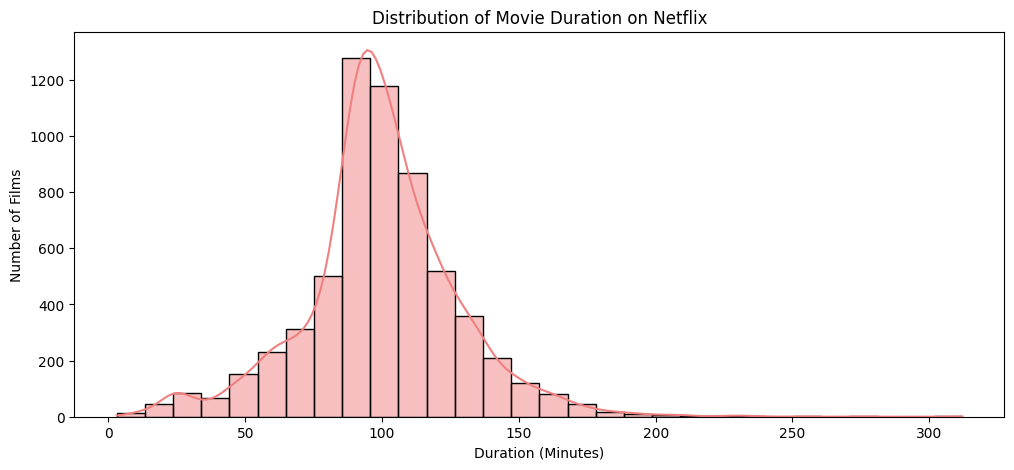

<ipython-input-15-d660bbd8cf56>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_tvshows_pd["duration"], palette="viridis")


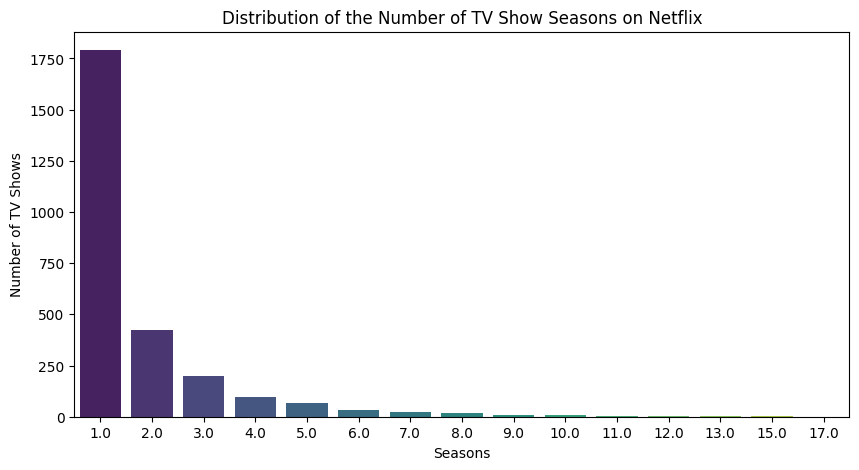

In [15]:
# Separate Movies and TV Shows
df_movies = df.filter(col("type") == "Movie")
df_tvshows = df.filter(col("type") == "TV Show")

# Convert Movie duration (remove 'min' and convert to integer)
df_movies = df_movies.withColumn("duration", regexp_replace(col("duration"), " min", ""))
df_movies = df_movies.filter(col("duration").rlike("^[0-9]+$"))  # Keep numeric values only
df_movies = df_movies.withColumn("duration", col("duration").cast("int"))

# Convert TV Show seasons (remove 'Season' and 's', then convert to integer)
df_tvshows = df_tvshows.withColumn("duration", regexp_replace(col("duration"), " Season", ""))
df_tvshows = df_tvshows.withColumn("duration", regexp_replace(col("duration"), "s", ""))
df_tvshows = df_tvshows.withColumn("duration", col("duration").cast("int"))

# Convert to Pandas for visualization (limit to avoid memory issues)
df_movies_pd = df_movies.toPandas()
df_tvshows_pd = df_tvshows.toPandas()

# Movie Duration Distribution Plot
plt.figure(figsize=(12, 5))
sns.histplot(df_movies_pd["duration"], bins=30, kde=True, color="lightcoral")
plt.xlabel("Duration (Minutes)")
plt.ylabel("Number of Films")
plt.title("Distribution of Movie Duration on Netflix")
plt.show()

# TV Show Seasons Distribution Plot
plt.figure(figsize=(10, 5))
sns.countplot(x=df_tvshows_pd["duration"], palette="viridis")
plt.xlabel("Seasons")
plt.ylabel("Number of TV Shows")
plt.title("Distribution of the Number of TV Show Seasons on Netflix")
plt.show()

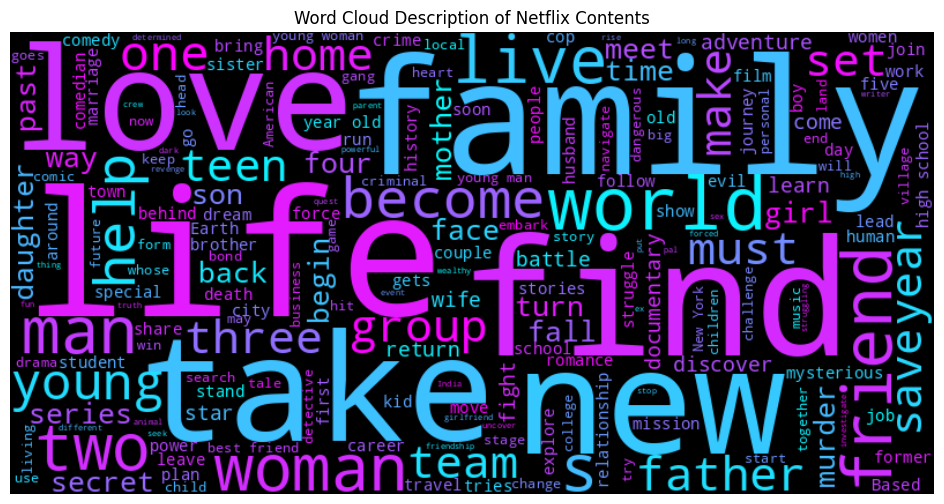

In [16]:
# Convert description column to Pandas for processing
df_description_pd = df.select("description").dropna().toPandas()

# Combine all descriptions into one large text
text = " ".join(df_description_pd["description"])

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="black",
                      colormap="cool").generate(text)

# Display Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud Description of Netflix Contents")
plt.show()

In [18]:
df.groupBy("type").count().show()

+-------+-----+
|   type|count|
+-------+-----+
|TV Show| 2674|
|  Movie| 6118|
+-------+-----+



In [19]:
from pyspark.ml.feature import StringIndexer, Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Select only required columns
df_model = df.select("description", "type").dropna()

# Encode 'type' column (Movie = 0, TV Show = 1)
indexer = StringIndexer(inputCol="type", outputCol="label")

# Tokenization: Split text into words
tokenizer = Tokenizer(inputCol="description", outputCol="words")

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# Convert words to numerical representation using TF-IDF
hashing_tf = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=1000)
idf = IDF(inputCol="raw_features", outputCol="features")



# Build ML Pipeline
preprocessing_pipeline  = Pipeline(stages=[indexer, tokenizer, remover, hashing_tf, idf])



# Transform dataset to get processed features
processed_df = preprocessing_pipeline.fit(df_model).transform(df_model)

# Select only the required columns
processed_df = processed_df.select("features", "label")

# Split data into train and test
train_df, test_df = processed_df.randomSplit([0.8, 0.2], seed=42)






In [22]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=100)
lr_model = lr.fit(train_df)
lr_predictions = lr_model.transform(test_df)

# Evaluate
lr_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
print(f"Logistic Regression Accuracy: {lr_evaluator.evaluate(lr_predictions):.4f}")

Logistic Regression Accuracy: 0.6686


In [23]:
from pyspark.sql.functions import col
from pyspark.sql import functions as F


In [24]:
# Define evaluator for Accuracy
lr_accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
lr_accuracy = lr_accuracy_evaluator.evaluate(lr_predictions)

# Define evaluator for F1-score
lr_f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
lr_f1_score = lr_f1_evaluator.evaluate(lr_predictions)

# Define evaluator for Precision
lr_precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
lr_precision = lr_precision_evaluator.evaluate(lr_predictions)

# Define evaluator for Recall
lr_recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
lr_recall = lr_recall_evaluator.evaluate(lr_predictions)

# Print the metrics
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"F1 Score: {lr_f1_score:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")


Accuracy: 0.6686
F1 Score: 0.6545
Precision: 0.6469
Recall: 0.6686


In [25]:
# Generate the Confusion Matrix
lr_conf_matrix = lr_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction")
lr_conf_matrix.show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|  965|
|  0.0|       1.0|  221|
|  1.0|       0.0|  340|
|  1.0|       1.0|  167|
+-----+----------+-----+



In [27]:
conf_matrix_pandas = lr_conf_matrix.toPandas().pivot(index="label", columns="prediction", values="count").fillna(0)
print(conf_matrix_pandas)

prediction  0.0  1.0
label               
0.0         965  221
1.0         340  167


In [28]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.functions import col


In [30]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize Random Forest Model
rf = RandomForestClassifier(
    featuresCol="features", labelCol="label",
    numTrees=300,  # Increase trees to improve accuracy
    maxDepth=10,  # Reduce depth to prevent overfitting
    featureSubsetStrategy="auto",  # Reduce feature correlation
    seed=42
)

# Train the model
rf_model = rf.fit(train_df)

# Make predictions
rf_predictions = rf_model.transform(test_df)


# Evaluate
rf_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
print(f"Random Forest Accuracy: {rf_evaluator.evaluate(rf_predictions):.4f}")


Random Forest Accuracy: 0.7005


In [31]:
# accuracy
rf_accuracy = rf_evaluator.evaluate(rf_predictions)

# Precision
rf_precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
rf_precision = rf_precision_evaluator.evaluate(rf_predictions)

# Recall
rf_recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
rf_recall = rf_recall_evaluator.evaluate(rf_predictions)

# F1-Score
rf_f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
rf_f1_score = rf_f1_evaluator.evaluate(rf_predictions)

print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-Score: {rf_f1_score:.4f}")

Accuracy: 0.7005
Precision: 0.4907
Recall: 0.7005
F1-Score: 0.5772


In [32]:
# Generate the Confusion Matrix
rf_conf_matrix = rf_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction")
rf_conf_matrix.show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0| 1186|
|  1.0|       0.0|  507|
+-----+----------+-----+



In [33]:
from pyspark.ml.classification import DecisionTreeClassifier

# Define Decision Tree Model
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

# Build Pipeline with Decision Tree
pipeline_dt = Pipeline(stages=[dt])

# Train the model
model_dt = pipeline_dt.fit(train_df)

# Predict on test data
dt_predictions = model_dt.transform(test_df)




In [34]:
# Define evaluator for Accuracy
dt_accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
dt_accuracy = dt_accuracy_evaluator.evaluate(dt_predictions)

# Define evaluator for F1-score
dt_f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
dt_f1_score = dt_f1_evaluator.evaluate(dt_predictions)

# Define evaluator for Precision
dt_precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
dt_precision = dt_precision_evaluator.evaluate(dt_predictions)

# Define evaluator for Recall
dt_recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
dt_recall = dt_recall_evaluator.evaluate(dt_predictions)

# Print the metrics
print(f"Accuracy: {dt_accuracy:.4f}")
print(f"F1 Score: {dt_f1_score:.4f}")
print(f"Precision: {dt_precision:.4f}")
print(f"Recall: {dt_recall:.4f}")


Accuracy: 0.7135
F1 Score: 0.6385
Precision: 0.6871
Recall: 0.7135


In [35]:
# Generate the Confusion Matrix
dt_conf_matrix = dt_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction")
dt_conf_matrix.show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0| 1147|
|  0.0|       1.0|   39|
|  1.0|       0.0|  446|
|  1.0|       1.0|   61|
+-----+----------+-----+



In [36]:
from pyspark.ml.classification import GBTClassifier

# Define GBT Model
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=20)

# Build Pipeline
pipeline_gbt = Pipeline(stages=[gbt])

# Train Model
model_gbt = pipeline_gbt.fit(train_df)

# Predict on test data
gbt_predictions = model_gbt.transform(test_df)




In [37]:
# Define evaluator for Accuracy
gbt_accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
gbt_accuracy = gbt_accuracy_evaluator.evaluate(gbt_predictions)

# Define evaluator for F1-score
gbt_f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
gbt_f1_score = gbt_f1_evaluator.evaluate(gbt_predictions)

# Define evaluator for Precision
gbt_precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
gbt_precision = gbt_precision_evaluator.evaluate(gbt_predictions)

# Define evaluator for Recall
gbt_recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
gbt_recall = gbt_recall_evaluator.evaluate(gbt_predictions)

# Print the metrics
print(f"Accuracy: {gbt_accuracy:.4f}")
print(f"F1 Score: {gbt_f1_score:.4f}")
print(f"Precision: {gbt_precision:.4f}")
print(f"Recall: {gbt_recall:.4f}")


Accuracy: 0.7165
F1 Score: 0.6466
Precision: 0.6923
Recall: 0.7165


In [38]:
# Generate the Confusion Matrix
gbt_conf_matrix = gbt_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction")
gbt_conf_matrix.show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0| 1143|
|  0.0|       1.0|   43|
|  1.0|       0.0|  437|
|  1.0|       1.0|   70|
+-----+----------+-----+



In [39]:
from pyspark.ml.classification import LinearSVC

# Define SVM Model
svm = LinearSVC(featuresCol="features", labelCol="label")

# Build Pipeline
pipeline_svm = Pipeline(stages=[svm])

# Train Model
model_svm = pipeline_svm.fit(train_df)

# Predict on test data
svm_predictions = model_svm.transform(test_df)




In [40]:
# Define evaluator for Accuracy
svm_accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
svm_accuracy = svm_accuracy_evaluator.evaluate(svm_predictions)

# Define evaluator for F1-score
svm_f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
svm_f1_score = svm_f1_evaluator.evaluate(svm_predictions)

# Define evaluator for Precision
svm_precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
svm_precision = svm_precision_evaluator.evaluate(svm_predictions)

# Define evaluator for Recall
svm_recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
svm_recall = svm_recall_evaluator.evaluate(svm_predictions)

# Print the metrics
print(f"Accuracy: {svm_accuracy:.4f}")
print(f"F1 Score: {svm_f1_score:.4f}")
print(f"Precision: {svm_precision:.4f}")
print(f"Recall: {svm_recall:.4f}")


Accuracy: 0.6716
F1 Score: 0.6577
Precision: 0.6504
Recall: 0.6716


In [41]:
# Generate the Confusion Matrix
svm_conf_matrix = svm_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction")
svm_conf_matrix.show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|  967|
|  0.0|       1.0|  219|
|  1.0|       0.0|  337|
|  1.0|       1.0|  170|
+-----+----------+-----+

